# Udacity Machine Learning Nanodegree Capstone Project
## Bank Marketing Campaign

The challenge is to design a model that will be able to predict whether a customer will respond to the marketing campaign based on his/her information. I will predict the `responded` target variable based on all the input variables provided.

The flow of the document will be in the following manner:
- Exploring the Data
- Data preprocessing/cleaning
- Evaluate Algorithms
- Model Tuning to Improve Result
- Final conclusion

# 1. Exploring the Data

### 1.1 Loading Libraries and data 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import xgboost as xgb
from time import time
import statsmodels.api as sm
from IPython.display import display
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



from sklearn.svm import SVC
%matplotlib inline

# Load the dataset
in_file = 'full_data.csv'
full_data = pd.read_csv(in_file)


### 1.2 Peek at the training data

In [2]:
# Print the first few entries of the Email Marketing Challenge data
display(full_data.head())

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       7763 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usag

### 1.3 Dimensions of data 

In [4]:
print("The training dataset has",full_data.shape[1],"columns and", full_data.shape[0],"rows")

The training dataset has 21 columns and 41188 rows


### 1.4 Overview of responses and overall response rate

In [5]:
# Calculate number of customers
n_customers = len(full_data)

# Calculate number of features
n_features = len(full_data.columns[:-1])     # 30 Feature cols and 1 target col 

# Calculate reponded customers
n_subscribed = len(full_data[full_data['y'] == 'yes'])

# Calculate not responded customers
n_not_subscribed = len(full_data[full_data['y'] == 'no'])

# Calculate response rate
response_rate = n_subscribed/(n_customers)*100

# Print the results
print("Total number of customers: {}".format(n_customers))
print("Number of features: {}".format(n_features))
print("Number of customers who subscribed: {}".format(n_subscribed))
print("Number of customers who did not subscribe: {}".format(n_not_subscribed))
print("Response rate of customers: {:.2f}%".format(response_rate))

Total number of customers: 41188
Number of features: 20
Number of customers who subscribed: 4640
Number of customers who did not subscribe: 36548
Response rate of customers: 11.27%


### 1.5 Statistical Summary

In [6]:
display(full_data.describe())

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,7763.0
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5191.0
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,0.0
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,5191.0
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5191.0
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.0
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5191.0
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5191.0


### 1.6 Exploratory Analysis - Data Visualization 

In [7]:
full_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

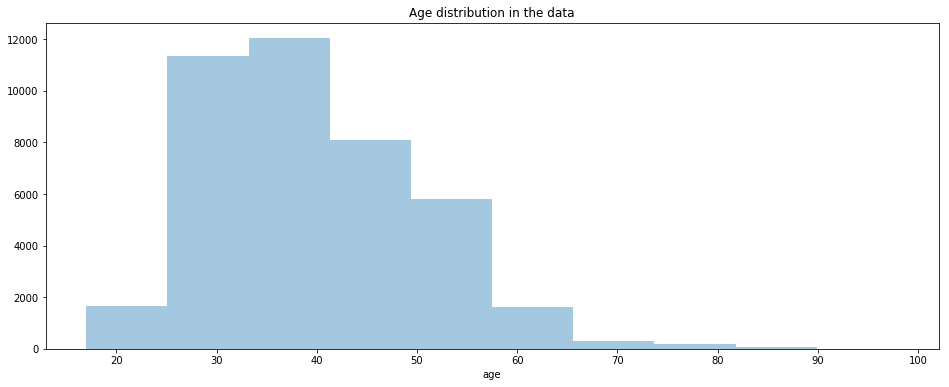

In [8]:
#histogram
h = sns.distplot(full_data['age'], bins=10, kde=False)
plt.title('Age distribution in the data')
h.figure.set_size_inches(16,6)

C:\Users\lo2lo\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


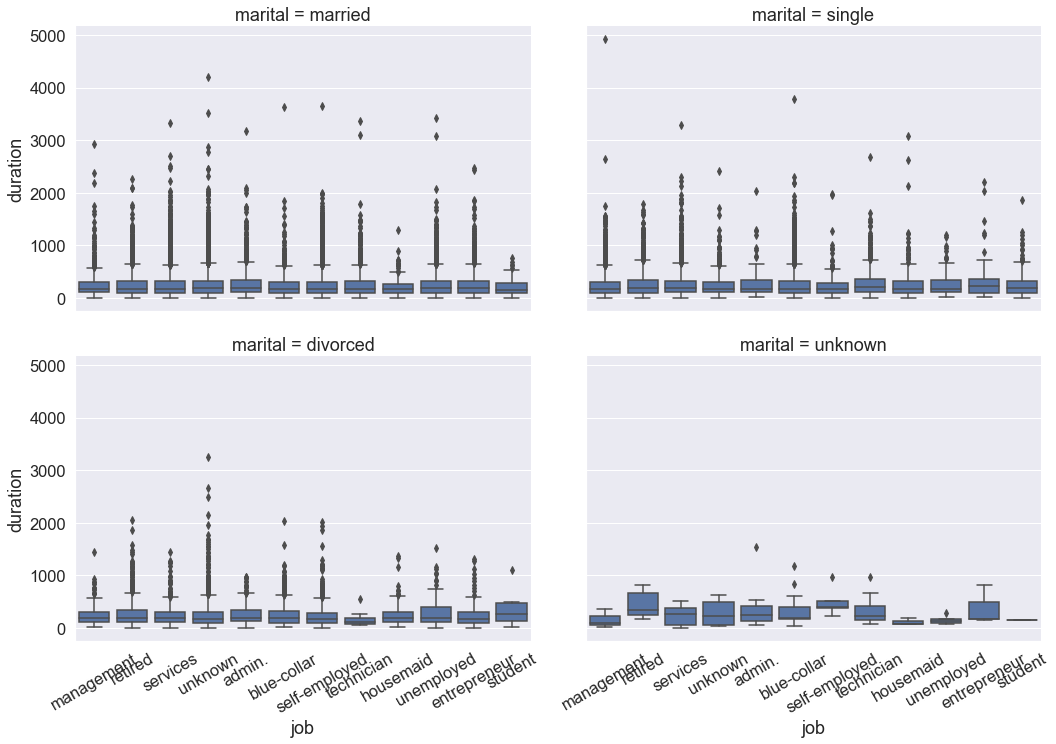

In [9]:
sns.set(font_scale=1.5)
g = sns.FacetGrid(full_data, col="marital", col_wrap=2, height=5, aspect=1.5)  
g.map(sns.boxplot, "job","duration").set_xticklabels(rotation=30)

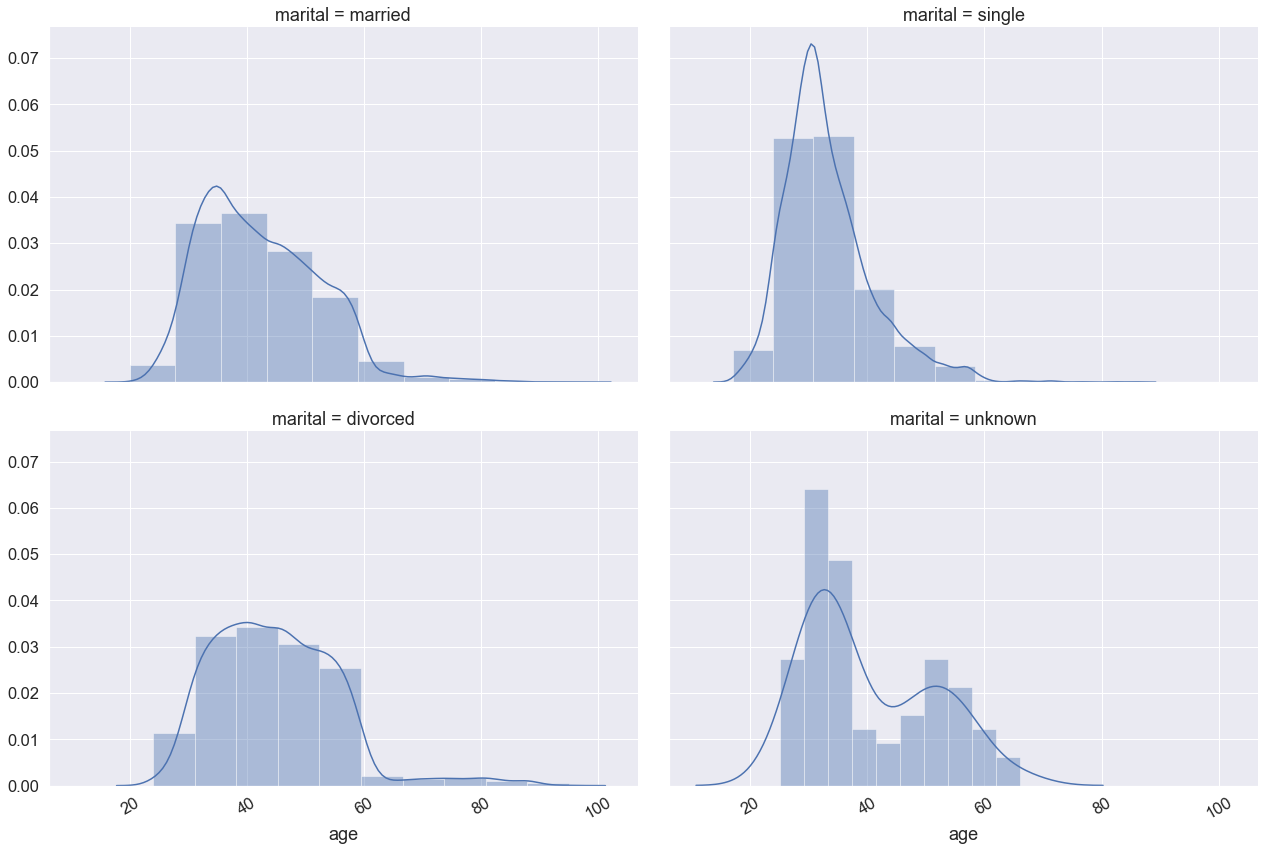

In [10]:
sns.set(font_scale=1.5)
g = sns.FacetGrid(full_data, col="marital", col_wrap=2, height=6, aspect=1.5)  
g.map(sns.distplot, "age", bins=10).set_xticklabels(rotation=30)

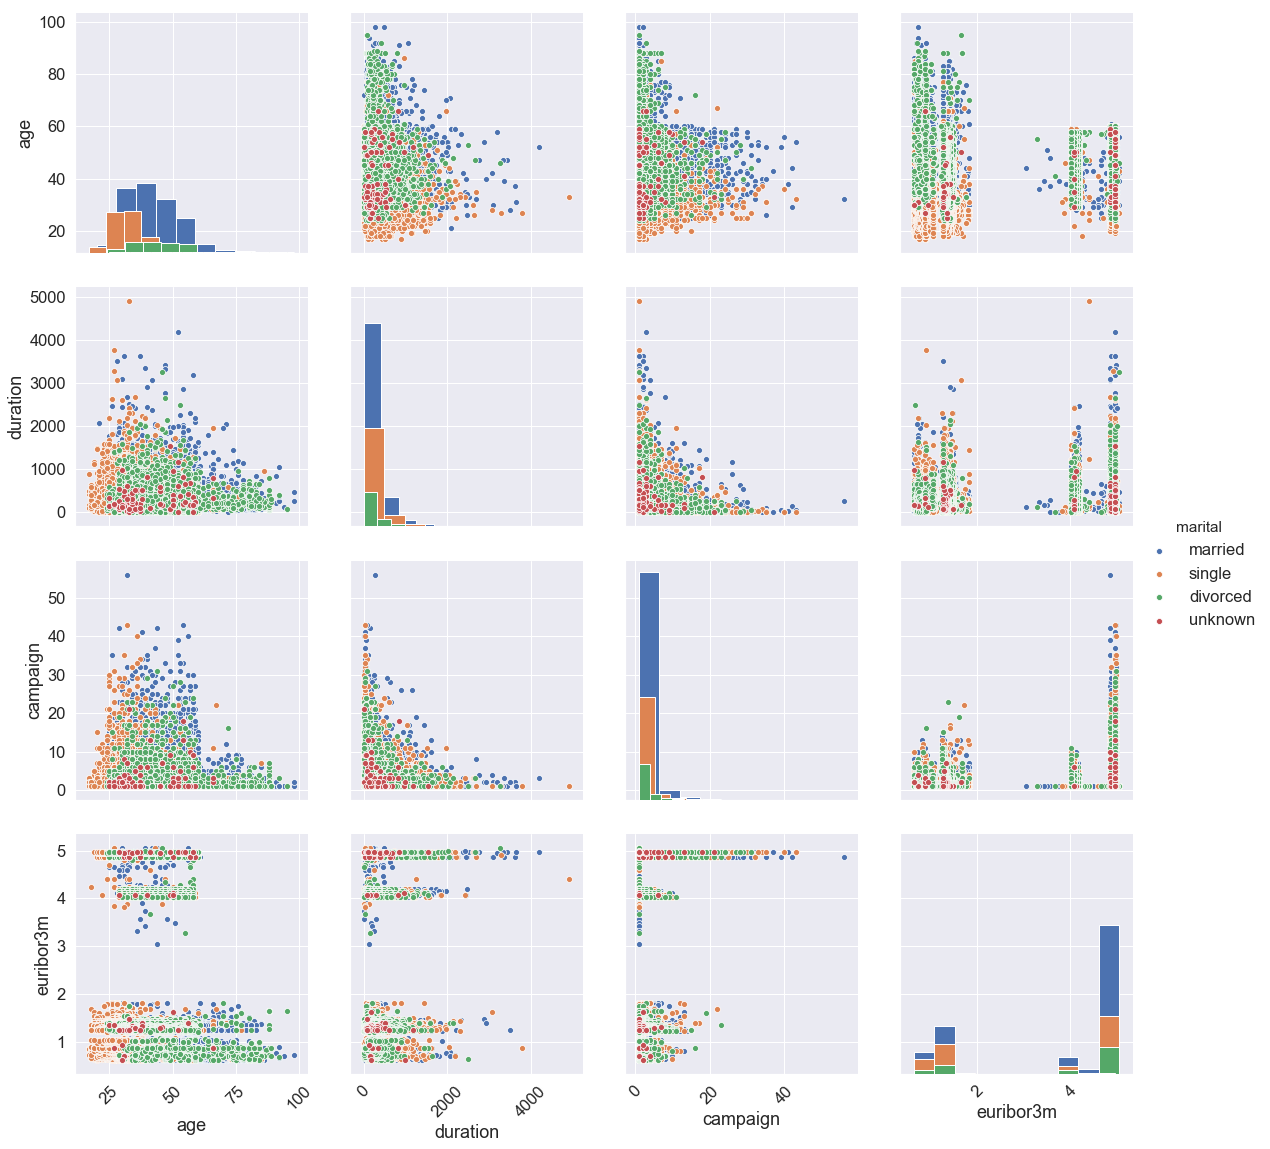

In [11]:
#'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
sns.set(font_scale=1.5)
g = sns.pairplot(full_data[["age", "duration", "marital", "campaign","euribor3m"]], hue="marital", diag_kind="hist", height=4)  
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

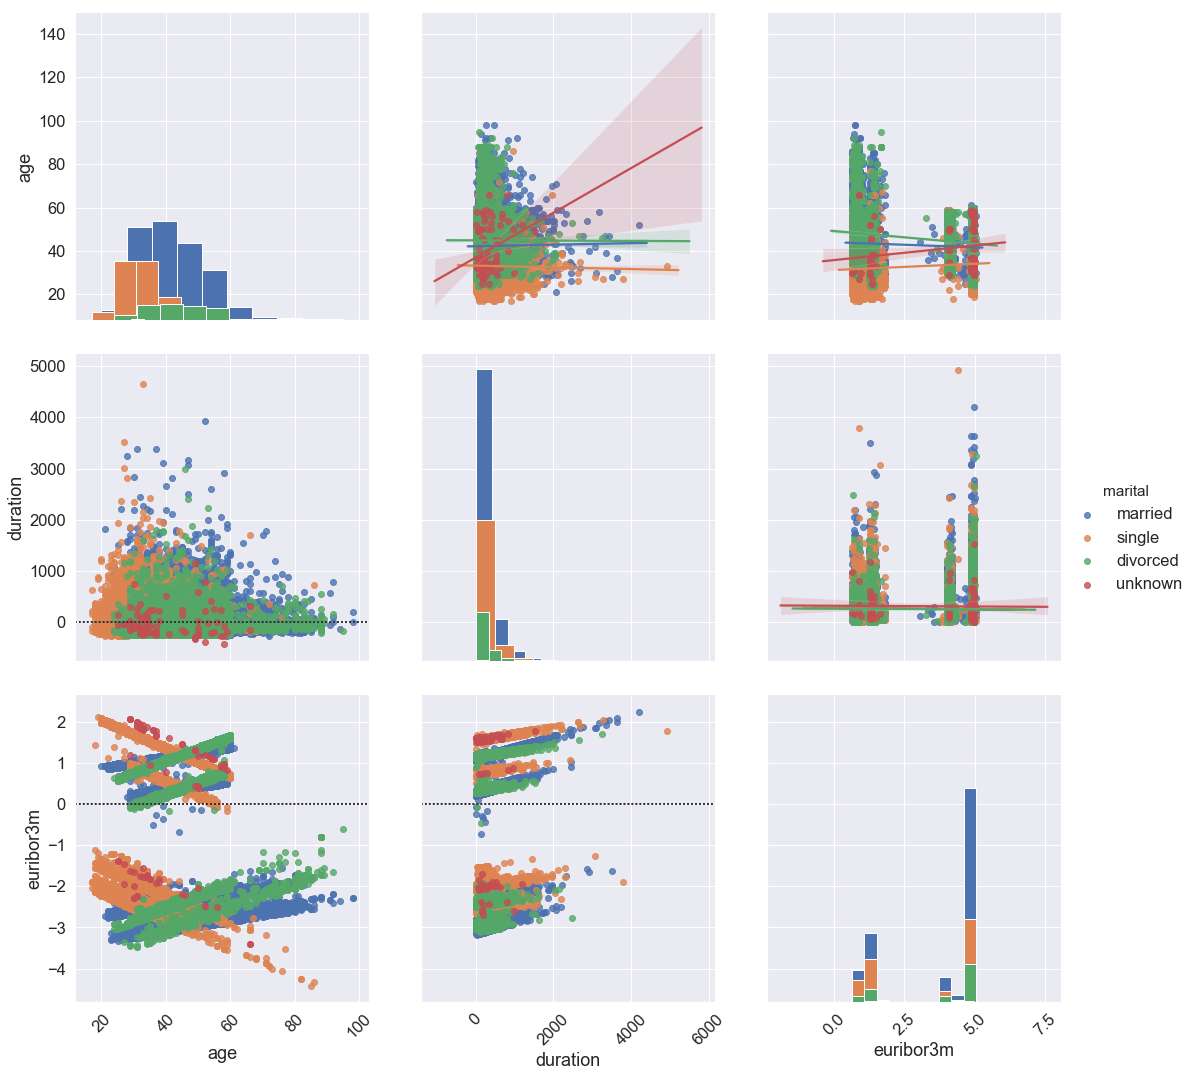

In [12]:
sns.set(font_scale=1.5)
g = sns.PairGrid(full_data[["age", "duration", "marital", "euribor3m"]], hue="marital", height=5)  
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)  
g.map_diag(plt.hist)  
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)
g.add_legend()  
g.set(alpha=0.5)

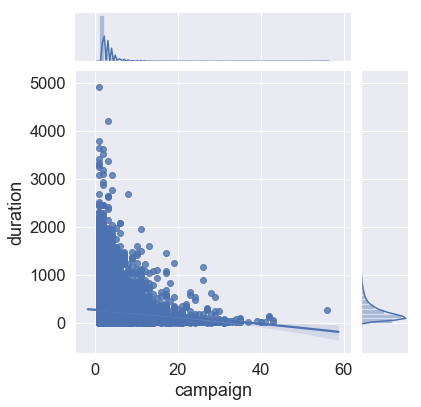

In [13]:
sns.set(font_scale=1.5)
g = sns.JointGrid(x="campaign", y="duration", data=full_data, height=6)  
g.plot_joint(sns.regplot, order=2)  
g.plot_marginals(sns.distplot)  

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

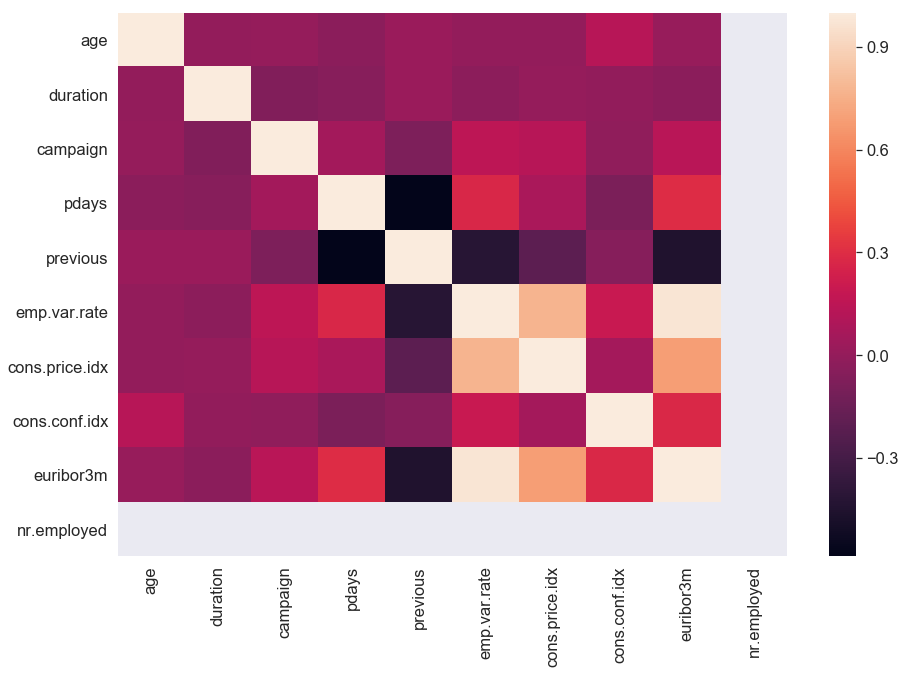

In [14]:
# visulize correlations of features with a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(full_data.corr())
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# 2. Data Preprocessing/Cleaning

In this section, I will prepare the data by splitting feature and target/label columns and also check for quality of given data and perform data cleaning. 
To check if the model I created is any good, I will split the data into `training` and `validation` sets to check the accuracy of the best model. We will split the given `training` data in two ,70% of which will be used to train our models and 30% we will hold back as a `validation` set. 

### 2.1 Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply yes/no, e.g. housing. These can be reasonably converted into 1/0 (binary) values.
Other columns, like profession and marital, have more than two values, and are known as categorical variables. The recommended way to handle such a column is to create as many columns as possible values (e.g. profession_admin, profession_blue-collar,  etc.), and assign a 1 to one of them and 0 to all others.
These generated columns are sometimes called dummy variables, and we will use the pandas.get_dummies() function to perform this transformation. The code cell below performs the preprocessing routine.

In [15]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no','unknown'], [1, 0, np.nan])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

full_data = preprocess_features(full_data)
print("Processed feature columns ({} total features):\n{}".format(len(full_data.columns), list(full_data.columns)))

Processed feature columns (55 total features):
['age', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'default', 'housing', 'loan', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'duration', 'campaign', 'pdays', 'previous', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']


### 2.2 Identify feature and target columns

In [16]:
# Extract feature columns
feature_cols = list(full_data.columns[:-1])

# Extract target column 'responded'
target_col = full_data.columns[-1] 

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = full_data[feature_cols]
y_all = full_data[target_col]

# Show the feature information by printing the first five rows
print("\nFeature values:")
print(X_all.head())

Feature columns:
['age', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'default', 'housing', 'loan', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'duration', 'campaign', 'pdays', 'previous', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Target column: y

Feature values:
   age  job_admin.  job_blue-

### 2.3 Data cleaning/washing 

Let's check how many missing values our dataset now has...

In [17]:
X_all.isnull().sum()

age                                  0
job_admin.                           0
job_blue-collar                      0
job_entrepreneur                     0
job_housemaid                        0
job_management                       0
job_retired                          0
job_self-employed                    0
job_services                         0
job_student                          0
job_technician                       0
job_unemployed                       0
marital_divorced                     0
marital_married                      0
marital_single                       0
education_basic.4y                   0
education_basic.6y                   0
education_basic.9y                   0
education_high.school                0
education_illiterate                 0
education_professional.course        0
education_university.degree          0
default                           8597
housing                            990
loan                               990
contact_cellular         

So looks like we have 4 columns that have missing values.

`default`, `housing` and `loan` are the four columns that has the most missing values but instead of dropping these altogether I will try to impute them as they may hold relevant information for the dataset. `nr.employed` has too many missing so we will go ahead and drop it.
To fill missing values, We will use `median` statistic.

In [18]:
X_all.drop('nr.employed',  axis=1, inplace=True)

C:\Users\lo2lo\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [19]:
X_all.fillna(X_all.median(), inplace=True)
X_all.describe()

C:\Users\lo2lo\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,campaign,pdays,previous,poutcome_failure,poutcome_nonexistent,poutcome_success,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,...,2.567593,962.475454,0.172963,0.103234,0.863431,0.033335,0.081886,93.575664,-40.502600,3.621291
std,10.42125,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,...,2.770014,186.910907,0.494901,0.304268,0.343396,0.179512,1.570960,0.578840,4.628198,1.734447
min,17.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000
25%,32.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,999.000000,0.000000,0.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000
50%,38.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,999.000000,0.000000,0.000000,1.000000,0.000000,1.100000,93.749000,-41.800000,4.857000
75%,47.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,999.000000,0.000000,0.000000,1.000000,0.000000,1.400000,93.994000,-36.400000,4.961000
max,98.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,56.000000,999.000000,7.000000,1.000000,1.000000,1.000000,1.400000,94.767000,-26.900000,5.045000


In [20]:
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (53 total features):
['age', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'default', 'housing', 'loan', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'duration', 'campaign', 'pdays', 'previous', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']


In [21]:
# Export cleaned data

filename = 'cleaned_X_all.csv'
X_all.to_csv(filename, index=False, encoding='utf-8')
filename = 'cleaned_y_all.csv'
y_all.to_csv(filename, index=False, encoding='utf-8')

In [22]:
# Read cleaned data directly
import numpy as np
import pandas as pd
from pandas import Series
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from time import time
from IPython.display import display
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

%matplotlib inline

in_file = 'cleaned_X_all.csv'
X_all = pd.read_csv(in_file)
in_file = 'cleaned_y_all.csv'
y_all = pd.read_csv(in_file, squeeze=True, header=None)

### 2.4 Training and Validation Data Split

So far, I have converted all categorical features into numeric values. For the next step, I will split the data (both features and corresponding labels) into training and test sets. In the code cell below, we will implement the following:
 - Randomly shuffle and split the data (`X_all, y_all`) into training and validation subsets.
 - Split training and validation into 70% and 30%.
 - Set a `random_state` for the function(s).
 - Store the results in `X_train, X_validation, y_train` and `y_validation`.

In [23]:
validation_size = 0.30
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_all, y_all, stratify = y_all, 
                                                    test_size = validation_size, random_state = 123)
print("Train set 'yes' pct = {:.2f}%".format(100 * (y_train == 1).mean()))
print("Validation  set 'yes' pct = {:.2f}%".format(100 * (y_validation == 1).mean()))

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Validation set has {} samples.".format(X_validation.shape[0]))

Train set 'yes' pct = 11.27%
Validation  set 'yes' pct = 11.26%
Training set has 28831 samples.
Validation set has 12357 samples.


# 3. Evaluating Models

We don't know which algorithms would be good on this problem or what configurations to use. So let's pick a few algorithms to evaluate.
 - Logistic Regression (LR)
 - Classification and Regression Trees (CART)
 - Random Forests (RF)
 - Adaptive Boosting (AB)
 - Extreme Gradient Boosting (XGB)
 
We are using 10-fold cross validation to estimate accuracy. This will split our dataset 10 parts, train on 9 and test on 1 and repeat for all combinations of train-test splits.
 
Also, we are using the metric of `accuracy` to evaluate models. This is a ratio of the number of correctly predicted instances in divided by the total number of instances in the dataset multiplied by 100 to give a percentage (e.g. 95% accurate). We will be using the `scoring` variable when we run build and evaluate each model next.

### Test to check how XGBoost compares with SKLearn wrapper

In [24]:
# Test to check how XGBoost compares with SKLearn wrapper

from xgboost.sklearn import XGBClassifier
clf = XGBClassifier()
param = clf.get_xgb_params()
clf.fit(X_train, y_train)
preds_sk = clf.predict(X_validation)

import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_validation)
bst = xgb.train(param, dtrain)
preds = bst.predict(dvalid).round()

print("Accurary of sklearn wrapper: ",accuracy_score(y_validation, preds_sk))
print("Accuracy of XGBoost library: ",accuracy_score(y_validation, preds.round()))
print("---------------------------------------------")
print("sklearn predictions: ", preds_sk)
print("XGB library predictions: ",preds)

Accurary of sklearn wrapper:  0.9184268026219956
Accuracy of XGBoost library:  0.9117099619648782
---------------------------------------------
sklearn predictions:  [1 0 0 ... 0 0 0]
XGB library predictions:  [1. 0. 0. ... 0. 0. 0.]


Accuracy of sklearn wrapper is much better so we would use that going forward.

### 3.1 Build Models 

In [25]:
scoring = 'accuracy'

#Spot check algorithms
models = []
models.append(('1. LR', LogisticRegression()))
models.append(('2. CART', DecisionTreeClassifier()))
models.append(('3. RF', RandomForestClassifier(n_estimators=100)))
models.append(('4. AB', AdaBoostClassifier(RandomForestClassifier(n_estimators=100), 
                                        algorithm='SAMME',n_estimators=100, learning_rate=1.0)))
#models.append(('5. XGB', XGBClassifier()))
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = 123)
    cv_results = model_selection.cross_val_score(model, X_train, y_train,
                                                cv = kfold, 
                                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1. LR: 0.909681 (0.005114)
2. CART: 0.890014 (0.005160)
3. RF: 0.912802 (0.006164)
4. AB: 0.913843 (0.007151)


### 3.2 Select Best Model

We now have 5 models and accuracy estimations for each. We need to compare the models to each other and select the most accurate. The output of above code cell shows `XGB` being the winner with highest estimated accuracy score. 

The plot below shows model evaluation results and compare the spread and the mean accuracy of each model. There is a population of accuracy measures for each algorithm beacuse each algortihm was evaluated 10 times (10 fold cross validation)

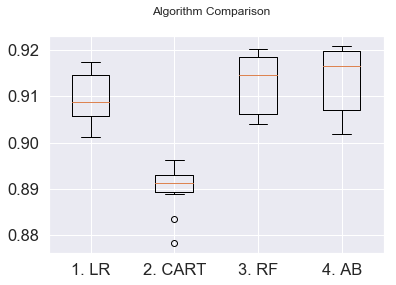

In [26]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The box and whisker plots are aligned at the top of the range near ~91% mark but appears `CART` is low performer and hovering in the ~89% range.

### 3.3 Make predictions on the validation set 

The `XGB` model was the most accurate model that we tested. Now we want to get an idea of accuracy of the model on our validation set.
This will give us an independent final check on the accuracy of th best model.

We can run the `XGB` model directly on the validation set and summarize the results as a final accuracy score, a confusion matrix and a classification report.

In [27]:
# Select best model
# Make predictions on validation dataset
xgb = XGBClassifier()
fit = xgb.fit(X_train, y_train)
xgb.pred = xgb.predict(X_validation)
print("Accuracy Score: ",accuracy_score(y_validation, xgb.pred))
print("----------------------------------------------------------")
print("Confusion Matrix: \n",confusion_matrix(y_validation, xgb.pred))
print("----------------------------------------------------------")
print("Classification Report: \n",classification_report(y_validation, xgb.pred))

Accuracy Score:  0.9184268026219956
----------------------------------------------------------
Confusion Matrix: 
 [[10615   350]
 [  658   734]]
----------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     10965
           1       0.68      0.53      0.59      1392

   micro avg       0.92      0.92      0.92     12357
   macro avg       0.81      0.75      0.77     12357
weighted avg       0.91      0.92      0.91     12357



We can see the accuracy is 0.918 or 91.8%. The confusion matrix provides an indication of the prediction errors made. Finally the classification report provides a breakdown of each class by precision, recall, f1-score and support.

# 4. Model Tuning

Let's starting with some tuning parameters

In [28]:
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

# fit model
model = XGBClassifier(seed = 123)
model.fit(X_train, y_train)

# printing the model for visualization
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
       subsample=1, verbosity=1)


## Parameter Tuning

In [29]:
# Tune objective
param_set0 = {
    'objective': ('reg:linear', 'binary:logistic','count:poisson')
}

xgb0 = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=123)

gsearch0 = GridSearchCV(estimator=xgb0, param_grid=param_set0, scoring='roc_auc', n_jobs=4, cv=5) #verbose=2
gsearch0.fit(X_train, y_train)
print(gsearch0.cv_results_)
print("----------------------------------------------------")
print(gsearch0.best_params_)
print("----------------------------------------------------")
print(gsearch0.best_score_)

{'mean_fit_time': array([6.33919053, 5.89625978, 5.03233204]), 'std_fit_time': array([0.22868231, 0.07687727, 1.00569168]), 'mean_score_time': array([0.0501195 , 0.04816575, 0.04129267]), 'std_score_time': array([0.01245364, 0.00940839, 0.01153048]), 'param_objective': masked_array(data=['reg:linear', 'binary:logistic', 'count:poisson'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'objective': 'reg:linear'}, {'objective': 'binary:logistic'}, {'objective': 'count:poisson'}], 'split0_test_score': array([0.94737647, 0.94696352, 0.94366305]), 'split1_test_score': array([0.94646082, 0.94452804, 0.94117797]), 'split2_test_score': array([0.94367012, 0.94108101, 0.93618121]), 'split3_test_score': array([0.94257027, 0.94156208, 0.93682814]), 'split4_test_score': array([0.94315275, 0.94360241, 0.93923457]), 'mean_test_score': array([0.94464633, 0.94354755, 0.93941718]), 'std_test_score': array([0.00190998, 0.00212889, 0.00276907]), 'rank

In [30]:
# Tune max_depth and min_child_weight

param_test1 = {
    'max_depth': [3,4,5,6,7,8,9],
    'min_child_weight': [2,3,4,5,6,7]
}

xgb1 = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=0, objective='reg:linear')
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring = 'roc_auc', n_jobs = 4, 
                        iid = False, cv = 5)
gsearch1.fit(X_train,y_train)

print(gsearch1.cv_results_)
print("----------------------------------------------------")
print(gsearch1.best_params_)
print("----------------------------------------------------")
print(gsearch1.best_score_)

{'mean_fit_time': array([ 5.46911426,  4.74614334,  5.01855426,  4.46753359,  4.26660366,
        4.35159183,  5.48203363,  6.10781064,  6.96713805,  7.30667281,
        7.05890384,  6.97952418,  8.84258695,  8.67380161,  8.26562614,
        9.33957891,  7.9854763 ,  7.11212025,  8.91944499,  9.3444427 ,
       11.27018013, 12.38747096, 13.50272608, 12.19508328, 15.13808575,
       14.3767725 , 13.83283195, 15.08240628, 13.2640583 , 11.57444811,
       15.17172933, 14.02305536, 14.17553277, 14.51701498, 15.67132487,
       18.25758529, 24.13170795, 19.10364571, 19.76952028, 18.85354729,
       14.8356863 , 12.21691575]), 'std_fit_time': array([0.36465544, 0.05655218, 0.12950351, 0.32838295, 0.13911319,
       0.27126068, 0.11230182, 0.55209497, 0.19577501, 0.26958941,
       0.3745773 , 0.40996588, 0.40397938, 0.34189149, 0.27698821,
       0.38429101, 0.39857984, 0.31161208, 0.31510833, 0.28643094,
       0.80118043, 0.20855406, 0.48748511, 0.62869195, 0.41786945,
       0.33639897, 0

In [31]:
# Tune gamma
param_test2 = {
    'gamma':[i/10.0 for i in range(1,10,1)]
}

xgb2 = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=0, objective='reg:linear', 
                     max_depth=5, min_child_weight=3)
gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, scoring = 'roc_auc',n_jobs = 4,
                         iid = False, cv = 5)
gsearch2.fit(X_train,y_train)

print(gsearch2.cv_results_)
print("----------------------------------------------------")
print(gsearch2.best_params_)
print("----------------------------------------------------")
print(gsearch2.best_score_)

{'mean_fit_time': array([9.06058946, 8.15845804, 8.14734511, 8.88780699, 9.43950276,
       8.39218769, 8.92467375, 7.47372532, 6.59088593]), 'std_fit_time': array([0.29654139, 0.21819339, 0.47917564, 0.45107813, 0.36887395,
       0.48759399, 0.56588208, 0.53383547, 1.59937487]), 'mean_score_time': array([0.04495363, 0.0666048 , 0.04621239, 0.04281907, 0.05000987,
       0.04479938, 0.058533  , 0.04300585, 0.03829837]), 'std_score_time': array([0.0146511 , 0.04719253, 0.01085029, 0.01147514, 0.00999547,
       0.01188692, 0.01730661, 0.00834893, 0.01455817]), 'param_gamma': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}, {'gamma': 0.5}, {'gamma': 0.6}, {'gamma': 0.7}, {'gamma': 0.8}, {'gamma': 0.9}], 'split0_test_score': array([0.95142181, 0.951

In [32]:
# Tune reg_alpha and reg_lambda
param_test3 = {
    'reg_alpha': (0,2,4),
    'reg_lambda': (1,3,5)
}

xgb3 = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=0, objective='reg:linear', 
                     max_depth=5, min_child_weight=3, gamma=0.1)
gsearch3 = GridSearchCV(estimator = xgb3, param_grid = param_test3, scoring = 'roc_auc',n_jobs = 4,
                         iid = False, cv = 5)
gsearch3.fit(X_train,y_train)

print(gsearch3.cv_results_)
print("----------------------------------------------------")
print(gsearch3.best_params_)
print("----------------------------------------------------")
print(gsearch3.best_score_)

{'mean_fit_time': array([ 9.36681275, 10.27473874, 10.34546008, 10.23411493, 10.60449862,
       10.73082018, 10.94660864, 10.37108178,  8.62141647]), 'std_fit_time': array([0.51173669, 0.19046378, 0.15004081, 0.45826371, 0.1295481 ,
       0.11911753, 0.12990386, 0.26175322, 2.598032  ]), 'mean_score_time': array([0.05698466, 0.04852605, 0.05567946, 0.051333  , 0.05655217,
       0.0463933 , 0.0562881 , 0.05814061, 0.03713341]), 'std_score_time': array([0.01816336, 0.00758251, 0.01047488, 0.01138059, 0.01201862,
       0.00806413, 0.01586245, 0.01310632, 0.00595557]), 'param_reg_alpha': masked_array(data=[0, 0, 0, 2, 2, 2, 4, 4, 4],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_reg_lambda': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dt

In [33]:
# Tune subsample, colsample_bytree and colsample_bylevel
param_test4 = {
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'colsample_bylevel': (0.5, 1)
}

xgb4 = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=0, objective='reg:linear', 
                     max_depth=5, min_child_weight=3, gamma=0.1, reg_alpha=2, reg_lambda=5)
gsearch4 = GridSearchCV(estimator = xgb4, param_grid = param_test4, scoring = 'roc_auc',n_jobs = 4,
                         iid = False, cv = 5)
gsearch4.fit(X_train,y_train)

print(gsearch4.cv_results_)
print("----------------------------------------------------")
print(gsearch4.best_params_)
print("----------------------------------------------------")
print(gsearch4.best_score_)

{'mean_fit_time': array([ 4.53702512,  4.09459801,  5.91492505,  5.47412214,  6.01385946,
        6.04087596, 10.81532793,  8.76153069]), 'std_fit_time': array([0.02959645, 0.28402376, 0.52938471, 0.26165048, 0.23880786,
       1.03436415, 1.445626  , 1.42858945]), 'mean_score_time': array([0.05142093, 0.05441356, 0.05180845, 0.04344816, 0.04715476,
       0.04645834, 0.05582571, 0.04814873]), 'std_score_time': array([0.00857817, 0.00984303, 0.01359733, 0.00382793, 0.00514978,
       0.00627555, 0.01692693, 0.01051416]), 'param_colsample_bylevel': masked_array(data=[0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_colsample_bytree': masked_array(data=[0.5, 0.5, 1, 1, 0.5, 0.5, 1, 1],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.5, 1, 0.5, 1, 0.5, 1, 0.

### Make predictions on the validation set based on tuned model

The `XGB` model was the most accurate model that we tested. Now we want to get an idea of accuracy of the model on our validation set.
This will give us an independent final check on the accuracy of th best model.

We can run the `XGB` model directly on the validation set and summarize the results as a final accuracy score, a confusion matrix and a classification report.

In [47]:
# Select best model
# Make predictions on validation dataset using tuned parameters
tuned_model = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=0, objective='reg:linear', 
                     max_depth=5, min_child_weight=3, gamma=0.1, reg_alpha=2, reg_lambda=5, subsample=1, 
                            colsample_bytree=1, colsample_bylevel=1)
tuned_fit = tuned_model.fit(X_train, y_train)
tuned_pred = tuned_model.predict(X_validation)

print("Accuracy Score: ",accuracy_score(y_validation, tuned_pred))
print("----------------------------------------------------------")
print("Confusion Matrix: \n",confusion_matrix(y_validation, tuned_pred))
print("----------------------------------------------------------")
print("Classification Report: \n",classification_report(y_validation, tuned_pred))

Accuracy Score:  0.9202880958161366
----------------------------------------------------------
Confusion Matrix: 
 [[10615   350]
 [  635   757]]
----------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.96     10965
           1       0.68      0.54      0.61      1392

   micro avg       0.92      0.92      0.92     12357
   macro avg       0.81      0.76      0.78     12357
weighted avg       0.91      0.92      0.92     12357

